# 0 引言

SciPy 是 Python 里处理科学计算 (scientific computing) 的包，使用它遇到问题可访问它的官网 (https://www.scipy.org/). 去找答案。 在使用 scipy 之前，需要引进它，语法如下：

In [7]:
import numpy as np
import scipy

这样你就可以用 scipy 里面所有的内置方法 (build-in methods) 了，比如插值、积分和优化。

但是每次写 scipy 字数有点多，通常我们给 scipy 起个别名 sp，用以下语法，这样所有出现 scipy 的地方都可以用 sp 替代。

In [5]:
import scipy as sp

SciPy 是建立 NumPy 基础上的，很多关于线性代数的矩阵运算在 NumPy 都能做，因此就不重复在这里讲了。此外在〖数组计算之 NumPy (下)〗也说过，数组计算比矩阵计算更通用，

本章换一种写法，我们专门针对科学计算中三个具体问题来介绍 SciPy，它们就是

* 插值 (interpolation)
* 积分 (integration)
* 优化 (optimization)

对于以上每一个知识点我都会介绍一个

* 简单例子来明晰 SciPy 里各种函数的用法

* 和金融相关的实际例子

    * 计算远期利率：在零息曲线中插值折现因子
    * 计算期权价格：将期望写成积分并数值求解
    * 配置资产权重：优化「风险平价」模型权重

# 1 插值

给定一组 (xi, yi)，其中 i = 1, 2, ..., n，而且 xi 是有序的，称为「标准点」。

插值就是对于任何新点 xnew，计算出对应的 ynew。换句话来说，插值就是在标准点之间建立分段函数 (piecewise function)，把它们连起来。这样给定任意连续 x 值，带入函数就能计算出任意连续 y 值。

在 SciPy 中有个专门的函数 scipy.interpolate 是用来插值的，首先引进它并记为 spi。 

In [6]:
import scipy.interpolate as spi 

### 简单例子

* 用 scipy.interpolate 来插值函数 sin(x) + 0.5x。

### 基本概念


首先定义 x 和函数 f(x)

In [8]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 11)
f = lambda x: np.sin(x) + 0.5 * x
f(x)

array([-3.14159265, -1.56221761, -1.29717034, -1.84442231, -1.57937505,
        0.        ,  1.57937505,  1.84442231,  1.29717034,  1.56221761,
        3.14159265])

接下来介绍 scipy.interpolate 里面两大杀器：splrep 和 splev。两个函数名称都是以 spl 开头，全称 spline (样条)，可以理解这两个函数都和样条有关。不同的是，两个函数名称以 rep 和 ev 结尾，它们的意思分别是：

* rep：representation 的缩写，那么 splrep 其实生成的是一个「表示样条的对象」
* ev：evaluation 的缩写，那么 splev 其实用于「在样条上估值」

splrep 和 splev 像是组合拳 (one two punch)

* 前者将 x, y 和插值方式转换成「样条对象」tck
* 后者利用它在 xnew 上生成 ynew

一图胜千言：
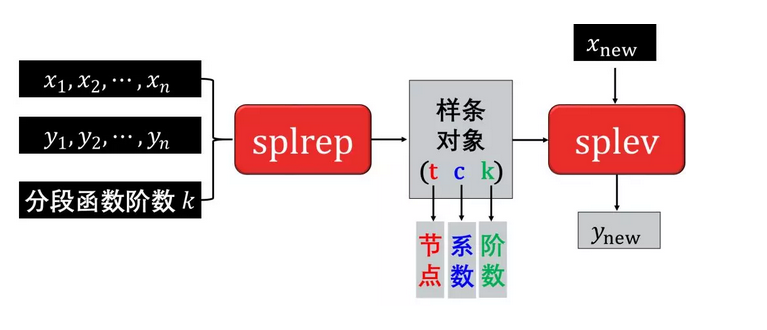

接下来仔细分析一下tck

In [10]:
tck = spi.splrep(x, f(x), k = 1)
tck

(array([-6.28318531, -6.28318531, -5.02654825, -3.76991118, -2.51327412,
        -1.25663706,  0.        ,  1.25663706,  2.51327412,  3.76991118,
         5.02654825,  6.28318531,  6.28318531]),
 array([-3.14159265, -1.56221761, -1.29717034, -1.84442231, -1.57937505,
         0.        ,  1.57937505,  1.84442231,  1.29717034,  1.56221761,
         3.14159265,  0.        ,  0.        ]),
 1)

tck 就是样条对象，以元组形式返回，tck 这名字看起来很奇怪，实际指的是元组 (t, c, k) 里的三元素：

* t - vector of knots (节点)
* c - spline cofficients (系数)
* k - degree of spline (阶数)

对照上图，tck 确实一个元组，包含两个 array 和一个标量 1，其中

* 第一个 array 是节点，即标准点，注意到一开始 x 只有 11 个，但现在是 13 个，首尾都往外补了一个和首尾一样的 x
* 第二个 array 是系数，注意它就是 y 在尾部补了两个 0
* 标量 1 是阶数，因为在调用 splrep 时就把 k 设成 1

虽然解释不清楚前两个 array，那就把 tck 当成是个黑匣子 (black-box) 直接用了。比如可用 PPoly.from_spline 来查看每个分段函数的系数。

In [11]:
pp = spi.PPoly.from_spline(tck)
pp.c.T

array([[ 1.25682673, -3.14159265],
       [ 1.25682673, -3.14159265],
       [ 0.21091791, -1.56221761],
       [-0.43548928, -1.29717034],
       [ 0.21091791, -1.84442231],
       [ 1.25682673, -1.57937505],
       [ 1.25682673,  0.        ],
       [ 0.21091791,  1.57937505],
       [-0.43548928,  1.84442231],
       [ 0.21091791,  1.29717034],
       [ 1.25682673,  1.56221761],
       [ 1.25682673,  3.14159265]])

tck 的系数数组里有 13 个元素，而上面数组大小是 (12, 2)，12 表示 12 段，2 表示每段线性函数由 2 个系数确定。

把 x 和 tck 丢进 splev 函数，我们可以插出在 x 点对应的值 iy。

In [12]:
iy = spi.splev(x, tck)
iy

array([-3.14159265, -1.56221761, -1.29717034, -1.84442231, -1.57937505,
        0.        ,  1.57937505,  1.84442231,  1.29717034,  1.56221761,
        3.14159265])

用 Matplotlib 来可视化插值的 iy 和原函数 f(x) 发现 iy 都在 f(x) 上。

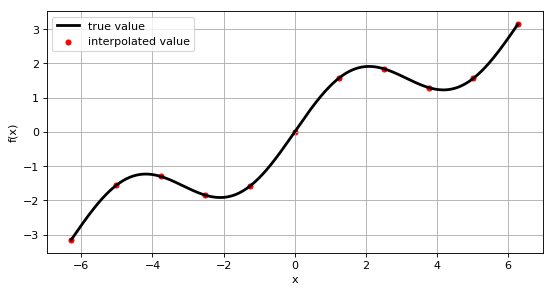

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4), dpi=80)
x_ = np.linspace(-2 * np.pi, 2 * np.pi, 1000)

plt.plot(x_, f(x_), color = 'black', linewidth=2.5, label='true value')
plt.scatter(x, iy, 20, color = 'red', label='interpolated value')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

除了可视化，我们还可以用具体的数值结果来评估插值的效果：

In [32]:
np.allclose(f(x), iy)
np.sum((f(x) - iy) ** 2) / len(x)

0.0

第一行 allclose 的结果都是 True 证明插值和原函数值完全吻合，第二行就是均方误差 (mean square error, MSE)，0.0 也说明同样结果。

上面其实做的是在「标准点 x」上插值，那得到的结果当然等于「标准点 y」了。这种插值确实意义不大，但举这个例子只想让大家

1. 明晰 splrep 和 splev 是怎么运作的
2. 如何可视化插出来的值和原函数的值
3. 如何用 allclose 来衡量插值和原函数值之间的差异

一旦弄明白了这些基础，接下来就可以秒懂更实际的例子了

### 正规例子
上面在「标准点 x」上插值有点作弊，现在我们在 50 个「非标准点 xd」上线性插值得到 iyd。

In [39]:
xd = np.linspace(1.0, 3.0, 50)
iyd = spi.splev(xd, tck)
print(xd, '\n\n', iyd)


[1.         1.04081633 1.08163265 1.12244898 1.16326531 1.20408163
 1.24489796 1.28571429 1.32653061 1.36734694 1.40816327 1.44897959
 1.48979592 1.53061224 1.57142857 1.6122449  1.65306122 1.69387755
 1.73469388 1.7755102  1.81632653 1.85714286 1.89795918 1.93877551
 1.97959184 2.02040816 2.06122449 2.10204082 2.14285714 2.18367347
 2.2244898  2.26530612 2.30612245 2.34693878 2.3877551  2.42857143
 2.46938776 2.51020408 2.55102041 2.59183673 2.63265306 2.67346939
 2.71428571 2.75510204 2.79591837 2.83673469 2.87755102 2.91836735
 2.95918367 3.        ] 

 [1.25682673 1.30812578 1.35942483 1.41072388 1.46202293 1.51332198
 1.56462103 1.58550795 1.59411685 1.60272574 1.61133464 1.61994353
 1.62855243 1.63716132 1.64577022 1.65437911 1.662988   1.6715969
 1.68020579 1.68881469 1.69742358 1.70603248 1.71464137 1.72325027
 1.73185916 1.74046805 1.74907695 1.75768584 1.76629474 1.77490363
 1.78351253 1.79212142 1.80073031 1.80933921 1.8179481  1.826557
 1.83516589 1.84377479 1.82798421 1.81

密密麻麻的数字啥都看不出来，可视化一下把。

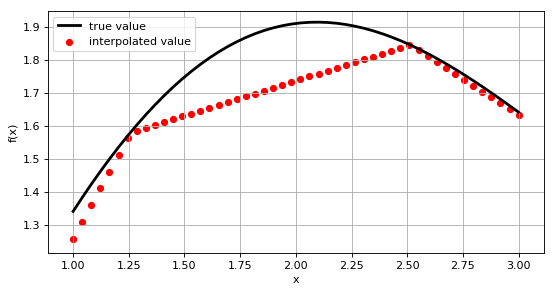

In [43]:
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(xd, f(xd), color = 'black', linewidth=2.5, label='true value')
plt.scatter(xd, iyd, 30, color = 'red', label='interpolated value')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

这插得是个什么鬼？红色插值点在第二段和深青色原函数差别也太远了吧 (MSE 也显示有差异)。

In [44]:
np.sum((f(xd) - iyd) ** 2) / len(xd)

0.011206417290260647

问题出在哪儿呢？当「标准点 x」不密集时 (只有 11 个)，分段线性函数来拟合 sin(x) + 0.5x 函数当然不会太好啦。那我们试试分段三次样条函数 (k = 3)。

In [46]:
tck = spi.splrep( x, f(x), k=3 )
iyd = spi.splev( xd, tck )

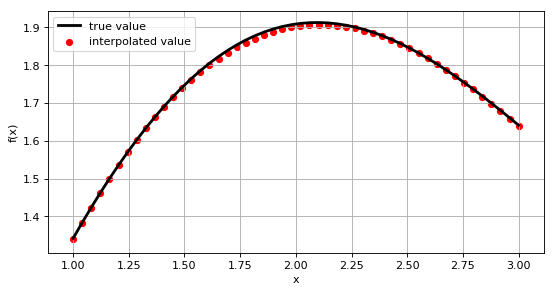

In [47]:
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(xd, f(xd), color = 'black', linewidth=2.5, label='true value')
plt.scatter(xd, iyd, 30, color = 'red', label='interpolated value')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [48]:
np.sum((f(xd) - iyd) ** 2) / len(xd)

1.6073247177220542e-05

视觉效果好多了！误差小多了！

# 2 积分

在 SciPy 中有个专门的函数 scipy.integrate 是用来做数值积分的，首先引进它并记为 sci。 


In [51]:
import scipy.integrate as sci

### 简单例子

### 用 scipy.integrate 来对函数 sin(x) + 0.5x 求积分。

首先定义被积函数 f(x)

In [52]:
f = lambda x: np.sin(x) + 0.5 * x

假设我们想从 x= 0.5 到 9.5 对 f(x) 求积分，可以手推出

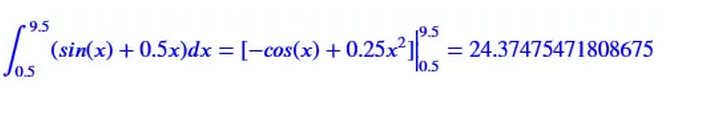

在 scipy.integrate 里还有些数值积分的函数：

* fixed_quad：fixed Gaussian quadrature (定点高斯积分)
* quad：adaptive quadrature (自适应积分)
* romberg：Romberg integration (龙贝格积分)
* trapz：用 trapezoidal 法则
* simps：用 Simpson’s 法则

前三个函数 fixed_quad, quad, romberg 的参数是被积函数、下界和上界。代码如下：

In [58]:
a = 0.5
b = 9.5
sci.fixed_quad(f, a, b)[0]

24.366995967084602

In [57]:
sci.quad(f, a, b)[0]


24.374754718086752

In [59]:
sci.romberg(f, a, b)

24.374754718086713

对后两个函数 trapz 和 simps，首先在上下界之间取 n 个点 xi，再求出对应的函数值 f(xi)，再把当参数 f(xi) 和 xi 传到函数中。代码如下：

In [61]:
xi = np.linspace(a, b, 100)
sci.trapz(f(xi),xi)

24.373463386819818

In [62]:
sci.simps(f(xi), xi)

24.37474011548407

和解析解 24.37475471808675 比较，quad 的结果最精确。一般当被积函数不规则时 (某段函数值激增)，quad (自适应积分) 的结果也是最好。

# 3 优化

在 SciPy 中有个专门的函数 scipy.optimize 是用来优化的，首先引进它并记为 spo。 

In [63]:
import scipy.optimize as spo

优化问题可分为无约束优化 (unconstrained optimization) 和有约束优化 (constrained optimization)

### 简单例子
用 scipy.optimize 来求出函数

    sin(x) + 0.05x2 + sin(y) + 0.05y2 

的最小值。

首先定义函数

In [66]:
f = lambda x, y: np.sin(x) + 0.05 * x ** 2 + np.sin(y) + 0.05 * y ** 2

该函数有多个局部最小值 (local minimum) 和一个全局最小值 (global minimum)。我们目标是求后者，主要步骤如下：

* 在 (x-y) 定义域上选点，求出函数值 f(x, y)，找出最小值对应的 x* 和 y*

* 用 x* 和 y* 当初始值，求出函数全局最小值

第一步：用蛮力找函数最小值以及对应的参数

之所以用「蛮力」一词，是因为接下来要用到 brute 函数，而 bruteforce 就是蛮力的意思。首先定义函数 fo (其实就是上面的 f)，只不过 brute 函数要求用一个元组把若干参数集合起来。此外我们添加一个 print() 语句，为了检查中间产出。

In [69]:
def fo(xy):
    x, y = xy
    z = np.sin(x) + 0.05 * x ** 2 + np.sin(y) + 0.05 * y ** 2
    if output == True:
        print('%8.4f %8.4f %8.4f' %(x, y, z))
    return z

将 x 和 y 在 -10 到 10 以步长为 5 来切片 (回顾切片是前闭后开的，因此切片完得到的是 -10, -5, 0, 5，而不包括 10 这个点)

In [70]:
output = True
rranges = ((-10, 10, 5), (-10, 10, 5))
spo.brute(fo, rranges, finish=None)

-10.0000 -10.0000  11.0880
-10.0000 -10.0000  11.0880
-10.0000  -5.0000   7.7529
-10.0000   0.0000   5.5440
-10.0000   5.0000   5.8351
 -5.0000 -10.0000   7.7529
 -5.0000  -5.0000   4.4178
 -5.0000   0.0000   2.2089
 -5.0000   5.0000   2.5000
  0.0000 -10.0000   5.5440
  0.0000  -5.0000   2.2089
  0.0000   0.0000   0.0000
  0.0000   5.0000   0.2911
  5.0000 -10.0000   5.8351
  5.0000  -5.0000   2.5000
  5.0000   0.0000   0.2911
  5.0000   5.0000   0.5822


array([0., 0.])

从上面结果可看出，函数在 (0, 0) 是取最小值 0。真是最小值吗？我也不知道，但是以 5 为步长是不是太粗糙了些，接下来用 0.1 为步长。这时把 output 设为 False 是因为不想看到打印的内容。

In [71]:
output = False
rranges = ((-10, 10, 0.1), (-10, 10, 0.1))
opt1 = spo.brute(fo, rranges, finish=None)
opt1

array([-1.4, -1.4])

In [72]:
fo([-1.4, -1.4])

-1.7748994599769203

当步长变小，我们能在更细的网格上计算函数值，这是函数在 (-1.4, -1.4) 取最小值 -1.7749，明显比函数在 (0, 0) 上的值 0 要小。

第二步：把参数当初始值，求函数全局最小值

如果网格足够密，上面 -1.7749 大概率是全局最小值而  (-1.4, -1.4) 是对应的最优解；如果网格不是足够密，那么以 (-1.4, -1.4) 当初始值，也能很大概率找到全局最小值。

用 fmin 函数，将刚才 opt1 传进去，并设定 x 和 f 的终止条件 xtol 和 ftol，和最多迭代次数 maxiter 和最多运行函数次数 maxfun。

In [73]:
output = True
opt2 = spo.fmin(fo, opt1, xtol=0.001, ftol=0.001, maxiter=15, maxfun=20)
opt2

 -1.4000  -1.4000  -1.7749
 -1.4700  -1.4000  -1.7743
 -1.4000  -1.4700  -1.7743
 -1.3300  -1.4700  -1.7696
 -1.4350  -1.4175  -1.7756
 -1.4350  -1.3475  -1.7722
 -1.4088  -1.4394  -1.7755
 -1.4438  -1.4569  -1.7751
 -1.4328  -1.4427  -1.7756
 -1.4591  -1.4208  -1.7752
 -1.4213  -1.4347  -1.7757
 -1.4235  -1.4096  -1.7755
 -1.4305  -1.4344  -1.7757
 -1.4168  -1.4516  -1.7753
 -1.4305  -1.4260  -1.7757
 -1.4396  -1.4257  -1.7756
 -1.4259  -1.4325  -1.7757
 -1.4259  -1.4241  -1.7757
 -1.4304  -1.4177  -1.7757
 -1.4270  -1.4288  -1.7757


array([-1.42702972, -1.42876755])

此时最优解为 (-1.42702972, -1.42876755)，而对应的函数值为

In [74]:
output = False
fo(opt2)

-1.7757246992239009

比刚才函数在 (-1.4, -1.4) 取的最小值 -1.7749 又小了一些。

好的初始值对求函数的最优解影响比较大。假设我们无脑的用 (2, 2) 当初始值，看看会发生什么。

In [75]:
output = False
opt3 = spo.fmin(fo, (2, 2), maxiter=250)
opt3

Optimization terminated successfully.
         Current function value: 0.015826
         Iterations: 46
         Function evaluations: 86


array([4.2710728 , 4.27106945])

# 4 总结
本帖只讨论用 SciPy 可以实现的三个应用

* 用 scipy.interpolate 来插值 (interpolation)
* 用 scipy.integrate 来积分 (integration)
* 用 scipy.optimize 来优化 (optimization)

学完此贴后，至少你可以解决以下具体金融问题 (training set )：

在折现曲线上插出折现因子和零息利率
数值积分求解期权价值
优化出风险平价模型的权重

举一反三一下，你还可以解决新的金融问题 (test set )：

1. 在波动平面上插出波动率
2. 数值积分求解而二维金融衍生品价值
3.优化出各种资产配置模型的权重 (加各种约束)

你可以的！

下篇讨论内容最丰富的 Pandas。Buckle Up and Stay Tuned!